# Hurricane Damage Detector

## Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown

In [2]:
!gdown --id 1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK
From (redirected): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK&confirm=t&uuid=a76d4b6f-ee85-4f4b-91a4-bbb6b0279be6
To: /content/hurricane_detector.zip
100% 39.7M/39.7M [00:03<00:00, 11.7MB/s]


In [3]:
!unzip -q hurricane_detector.zip

replace train_hurricane/no_damage/-95.638504_29.838933.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
ls -l

total 38748
-rw-r--r-- 1 root root 39662128 Apr  5  2024 hurricane_detector.zip
drwxr-xr-x 1 root root     4096 Jun 26 13:35 sample_data/
drwxr-xr-x 4 root root     4096 Jun 30 06:51 test_hurricane/
drwxr-xr-x 4 root root     4096 Jun 30 06:51 train_hurricane/


In [5]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [6]:
!tree --dirsfirst --filelimit 2 ./train_hurricane/

./train_hurricane/
├── damage  [655 entries exceeds filelimit, not opening dir]
└── no_damage  [703 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [7]:
!tree --dirsfirst --filelimit 2 ./test_hurricane/

./test_hurricane/
├── damage  [5895 entries exceeds filelimit, not opening dir]
└── no_damage  [6333 entries exceeds filelimit, not opening dir]

2 directories, 0 files


## Load Dependencies

In [8]:
# === Standard Library Imports ===
from typing import Any, Dict, Sequence, Tuple, Union

# === Third-Party Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

# === Scikit-learn Imports ===
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

# === TensorFlow/Keras Imports ===
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    Dropout,
    BatchNormalization
)
from tensorflow.keras import layers

# === tf-keras-vis Import ===
from tf_keras_vis.gradcam import Gradcam

# === Version Info ===
print('TensorFlow Version:', tf.__version__)

TensorFlow Version: 2.18.0


## Utility functions to create dataset generators

In [9]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )
    test_ds = test_ds.map(lambda image, label: (tf.image.resize(image, (224, 224)), label)).prefetch(buffer_size=tf.data.AUTOTUNE)

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_ds,test_labels, predictions


In [10]:
train_ds, val_ds = prepare_train_and_val_datasets()
train_ds.take(1)

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Data augmentation:

In [11]:
def augment_pipeline(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize to (224, 224)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, lower=0.2, upper=1.5)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 255)          # Clip to valid range
    image = tf.cast(image, tf.uint8)                 # Cast if necessary
    return image, label

train_ds = train_ds.map(augment_pipeline).shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda image, label: (tf.image.resize(image, (224, 224)), label)).prefetch(buffer_size=tf.data.AUTOTUNE)

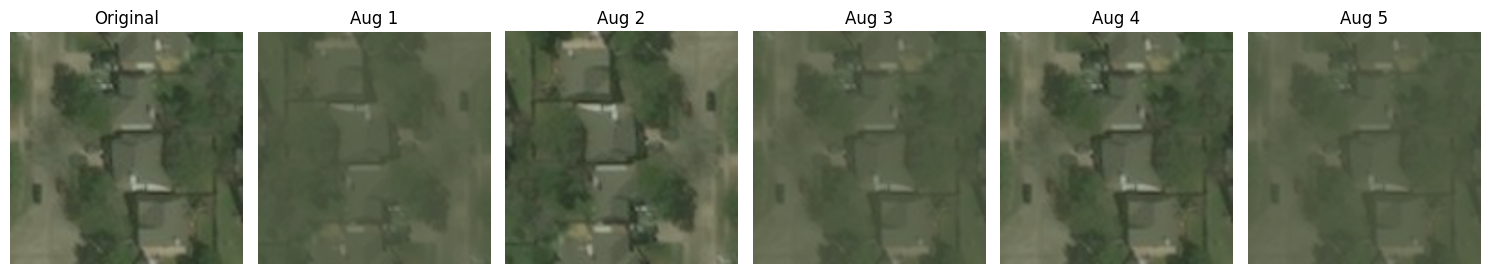

In [12]:
# Number of augmentations to visualize
N = 5

# Retrieve a sample image and label from train_ds (take(1) returns a dataset of one element)
for sample_img, sample_label in train_ds.unbatch().take(1):
    img = sample_img
    break

# Function to apply augmentation pipeline (for visualization)
def augment_only_image(image):
    image = tf.image.resize(image, (224, 224))  # Resize to (224, 224)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, lower=0.2, upper=1.5)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 255)          # Clip to valid range
    image = tf.cast(image, tf.uint8)                 # Cast if necessary
    return image.numpy().astype(np.uint8)

# Generate N augmented versions
augmented_images = [augment_only_image(img) for _ in range(N)]

# Plot original + N augmentations
plt.figure(figsize=(15, 3))
plt.subplot(1, N + 1, 1)
plt.imshow(img.numpy().astype(np.uint8))
plt.title('Original')
plt.axis('off')

for i, aug_img in enumerate(augmented_images):
    plt.subplot(1, N + 1, i + 2)
    plt.imshow(aug_img)
    plt.title(f'Aug {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


# Data visualization:

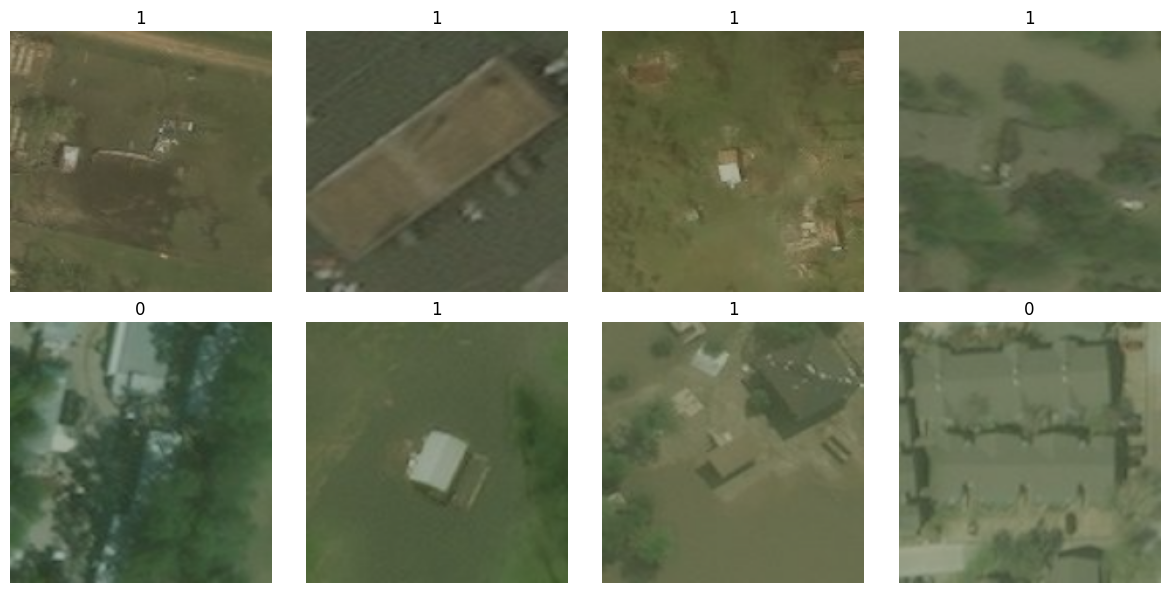

In [13]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

# Base model:
resnet50


In [14]:
# Load base model (without top)
base_model = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3)
)


In [15]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [16]:
for layer in base_model.layers[:]:
  if layer.trainable == True:
    print(layer.name, layer.trainable)

input_layer True
conv1_pad True
conv1_conv True
conv1_bn True
conv1_relu True
pool1_pad True
pool1_pool True
conv2_block1_1_conv True
conv2_block1_1_bn True
conv2_block1_1_relu True
conv2_block1_2_conv True
conv2_block1_2_bn True
conv2_block1_2_relu True
conv2_block1_0_conv True
conv2_block1_3_conv True
conv2_block1_0_bn True
conv2_block1_3_bn True
conv2_block1_add True
conv2_block1_out True
conv2_block2_1_conv True
conv2_block2_1_bn True
conv2_block2_1_relu True
conv2_block2_2_conv True
conv2_block2_2_bn True
conv2_block2_2_relu True
conv2_block2_3_conv True
conv2_block2_3_bn True
conv2_block2_add True
conv2_block2_out True
conv2_block3_1_conv True
conv2_block3_1_bn True
conv2_block3_1_relu True
conv2_block3_2_conv True
conv2_block3_2_bn True
conv2_block3_2_relu True
conv2_block3_3_conv True
conv2_block3_3_bn True
conv2_block3_add True
conv2_block3_out True
conv3_block1_1_conv True
conv3_block1_1_bn True
conv3_block1_1_relu True
conv3_block1_2_conv True
conv3_block1_2_bn True
conv3_bl

In [17]:
for layer in base_model.layers[:]:
    layer.trainable = False

for layer in base_model.layers[:]:
  if layer.trainable == True:
    print(layer.name, layer.trainable)

In [18]:
# Add custom layers
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

# Construct the model
new_model = Model(inputs=base_model.input, outputs=output)


In [19]:
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,625 (90.98 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

In [20]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
history = new_model.fit(
    train_ds, epochs=20,
    validation_data=val_ds,
)

test_ds, test_labels, predictions = eval_model_on_test(new_model)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 484ms/step - accuracy: 0.5795 - loss: 0.8654 - val_accuracy: 0.7749 - val_loss: 0.4662
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.7142 - loss: 0.6456 - val_accuracy: 0.7823 - val_loss: 0.4254
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.7674 - loss: 0.5313 - val_accuracy: 0.8118 - val_loss: 0.3731
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8154 - loss: 0.4448 - val_accuracy: 0.8413 - val_loss: 0.3387
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8271 - loss: 0.4349 - val_accuracy: 0.8561 - val_loss: 0.3243
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8102 - loss: 0.4411 - val_accuracy: 0.8708 - val_loss: 0.2819
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8700 - loss: 0.3361 - val_accuracy: 0.8782 - val_loss: 0.2598
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8289 - loss: 0.3940 - val_accuracy: 0

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step


Predicting on Test Data:   1%|          | 1/96 [00:04<06:38,  4.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:04<03:07,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:05<01:59,  1.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:05<01:27,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:05<01:09,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:06<00:58,  1.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:06<00:51,  1.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:07<00:46,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:07<00:43,  2.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:08<00:41,  2.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:08<00:39,  2.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:08<00:38,  2.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:09<00:37,  2.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:09<00:36,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:10<00:35,  2.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:10<00:34,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:11<00:34,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:11<00:33,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:11<00:33,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:12<00:32,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:12<00:32,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:13<00:31,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:13<00:31,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:14<00:30,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:14<00:30,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:14<00:30,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:15<00:29,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:15<00:30,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:16<00:29,  2.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:16<00:29,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:17<00:28,  2.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:17<00:28,  2.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:18<00:27,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:18<00:27,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:18<00:26,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:19<00:26,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:19<00:25,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:20<00:25,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:20<00:25,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:21<00:24,  2.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:21<00:24,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:21<00:23,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:22<00:22,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:22<00:22,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:23<00:22,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:23<00:21,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:24<00:21,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:24<00:20,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:25<00:20,  2.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:25<00:20,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:25<00:19,  2.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:26<00:19,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:26<00:18,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:27<00:18,  2.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:27<00:18,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:28<00:17,  2.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:28<00:16,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:28<00:16,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:29<00:15,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:29<00:15,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:30<00:15,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:30<00:14,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:31<00:14,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:31<00:13,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:32<00:13,  2.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:32<00:13,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:32<00:12,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:33<00:12,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:33<00:11,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:34<00:11,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:34<00:10,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:35<00:10,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:35<00:09,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:35<00:09,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:36<00:09,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:36<00:08,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:37<00:08,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:37<00:07,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:38<00:07,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:38<00:07,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:38<00:06,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:39<00:06,  2.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:39<00:05,  2.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:40<00:05,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:40<00:04,  2.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:41<00:04,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:41<00:03,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:41<00:03,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:42<00:03,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:42<00:02,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:43<00:02,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:43<00:01,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:44<00:01,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:44<00:00,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:44<00:00,  2.35it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


Predicting on Test Data: 100%|██████████| 96/96 [00:49<00:00,  1.93it/s]


In [22]:
binary_preds = (predictions > 0.5).astype(int)
binary_preds.shape, test_labels.shape

((12228,), (12228,))

In [23]:
from typing import Sequence, Any, List, Optional
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def plot_classification_summary_multifit(
    predictions: Sequence[float],
    test_labels: Sequence[int],
    histories: List[Any],
    title: str = "Classification Results",
    threshold: float = 0.5,
    class_names: Sequence[str] = ("no_damage", "damage"),
    phase_labels: Optional[List[str]] = None
) -> None:
    """
    Plots confusion matrix, concatenated training/validation accuracy and loss curves for multiple fits,
    and prints classification metrics for binary classification.

    Args:
        predictions (Sequence[float]): Model predictions (probabilities or logits).
        test_labels (Sequence[int]): True labels.
        histories (List[Any]): List of Keras History objects (from model.fit()).
        title (str): Plot title.
        threshold (float): Threshold to binarize predictions.
        class_names (Sequence[str]): Class names.
        phase_labels (Optional[List[str]]): Optional labels for each training phase.
    """
    # Prepare binary predictions
    binary_preds = (np.array(predictions) > threshold).astype(int)
    cm = confusion_matrix(test_labels, binary_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Prepare concatenated metrics
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    phase_starts = [0]
    for hist in histories:
        acc.extend(hist.history.get('accuracy', []))
        val_acc.extend(hist.history.get('val_accuracy', []))
        loss.extend(hist.history.get('loss', []))
        val_loss.extend(hist.history.get('val_loss', []))
        phase_starts.append(len(acc))
    # Remove the final redundant index
    phase_starts = phase_starts[:-1]
    n_epochs = len(acc)

    # Multi-plot
    fig, axs = plt.subplots(1, 3, figsize=(21, 6))

    # 1. Confusion Matrix
    disp.plot(ax=axs[0], cmap=plt.cm.Blues, colorbar=False)
    axs[0].set_title("Confusion Matrix")
    axs[0].set_xlabel('Predicted Label')
    axs[0].set_ylabel('True Label')

    # 2. Accuracy Plot
    axs[1].plot(acc, label='Training Accuracy', marker='o')
    axs[1].plot(val_acc, label='Validation Accuracy', marker='s')
    for i, start in enumerate(phase_starts[1:], 1):
        axs[1].axvline(start, color='k', linestyle=':', alpha=0.7)
        if phase_labels and i < len(phase_labels):
            axs[1].text(start + 0.5, axs[1].get_ylim()[1] * 0.97, phase_labels[i], rotation=90, va='top', ha='right', fontsize=9, alpha=0.7)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].legend()
    axs[1].grid(alpha=0.3)

    # 3. Loss Plot
    axs[2].plot(loss, label='Training Loss', marker='o')
    axs[2].plot(val_loss, label='Validation Loss', marker='s')
    for i, start in enumerate(phase_starts[1:], 1):
        axs[2].axvline(start, color='k', linestyle=':', alpha=0.7)
        if phase_labels and i < len(phase_labels):
            axs[2].text(start + 0.5, axs[2].get_ylim()[1] * 0.97, phase_labels[i], rotation=90, va='top', ha='right', fontsize=9, alpha=0.7)
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Loss')
    axs[2].set_title('Loss')
    axs[2].legend()
    axs[2].grid(alpha=0.3)

    plt.suptitle(title, fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Print detailed classification metrics
    print(classification_report(test_labels, binary_preds, target_names=class_names))

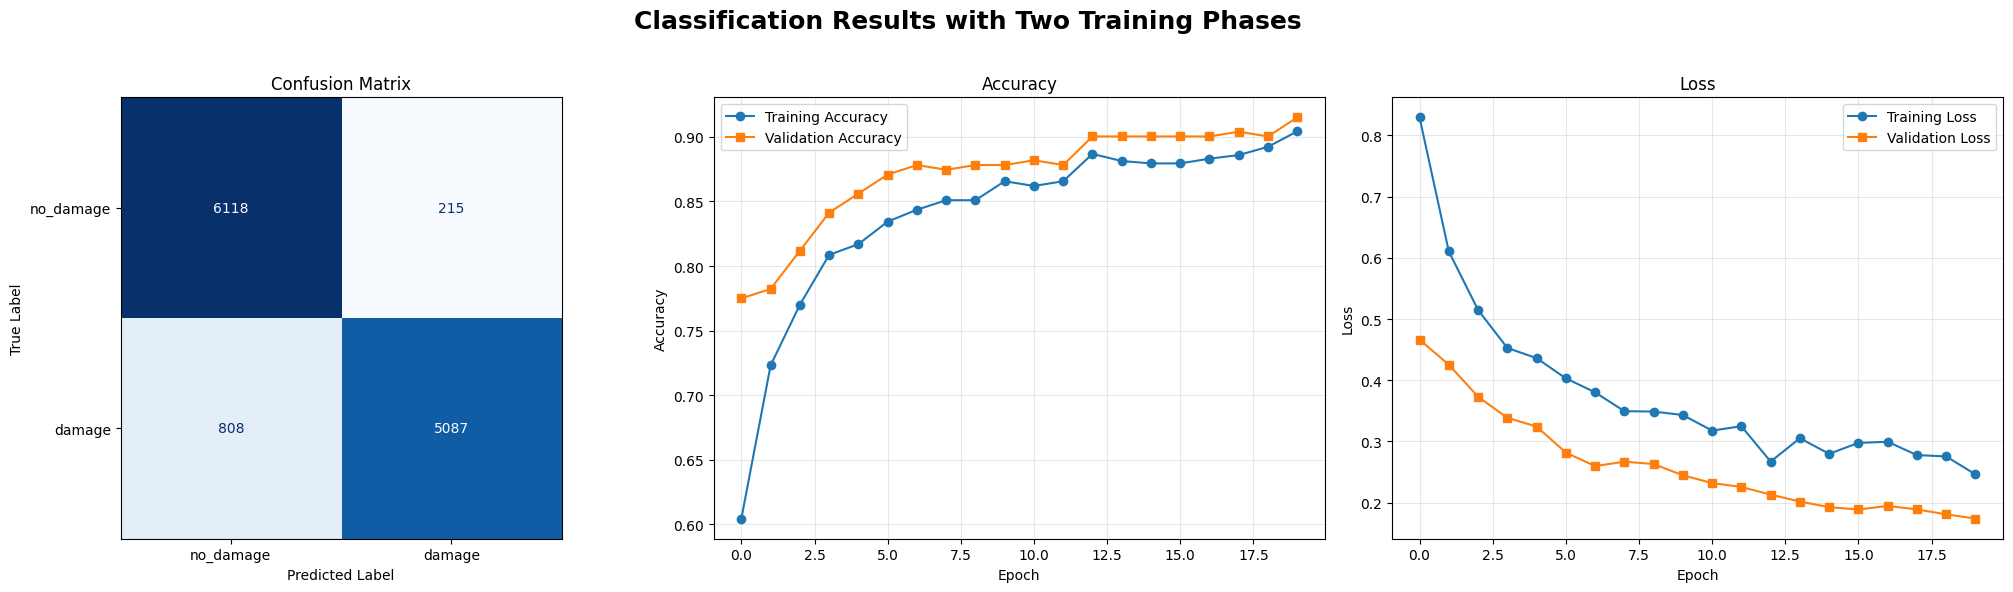

              precision    recall  f1-score   support

   no_damage       0.88      0.97      0.92      6333
      damage       0.96      0.86      0.91      5895

    accuracy                           0.92     12228
   macro avg       0.92      0.91      0.92     12228
weighted avg       0.92      0.92      0.92     12228



In [24]:
plot_classification_summary_multifit(
    predictions=binary_preds,
    test_labels=test_labels,
    histories=[history],  # List of Keras History objects
    title="Classification Results with Two Training Phases",
    class_names=["no_damage", "damage"],
    phase_labels=["Phase 1", "Phase 2"]
)


In [25]:
def normalize_for_display(img):
    """
    Normalize any image array to [0, 1] float range for correct matplotlib display.
    Handles both float and integer input types.
    """
    img = np.array(img)
    if img.dtype == np.uint8:
        return img
    img_min = img.min()
    img_max = img.max()
    if img_max > img_min:
        norm_img = (img - img_min) / (img_max - img_min)
        norm_img = np.clip(norm_img, 0, 1)
        return norm_img
    else:
        return np.zeros_like(img)
    plt.imshow(normalize_for_display(images[idx]))

In [26]:
def plot_false_negatives_positives(
    images: np.ndarray,
    test_labels: np.ndarray,
    binary_preds: np.ndarray,
    n_show: int = 8,
    title: str = "False Negatives and False Positives"
) -> None:
    images = np.array(images)
    test_labels = np.array(test_labels)
    binary_preds = np.array(binary_preds)

    false_negatives = np.where((binary_preds == 0) & (test_labels == 1))[0]
    false_positives = np.where((binary_preds == 1) & (test_labels == 0))[0]

    n_fn = min(n_show, len(false_negatives))
    n_fp = min(n_show, len(false_positives))
    n_cols = max(n_fn, n_fp)
    fig, axes = plt.subplots(2, n_cols, figsize=(3 * n_cols, 6))

    if n_cols == 1:
        axes = axes.reshape(2, 1)

    for i in range(n_fn):
        idx = false_negatives[i]
        axes[0, i].imshow(normalize_for_display(images[idx]))
        axes[0, i].set_title(f"FN\nIdx: {idx}")
        axes[0, i].axis("off")
    for i in range(n_fn, n_cols):
        axes[0, i].axis("off")

    for i in range(n_fp):
        idx = false_positives[i]
        axes[1, i].imshow(normalize_for_display(images[idx]))
        axes[1, i].set_title(f"FP\nIdx: {idx}")
        axes[1, i].axis("off")
    for i in range(n_fp, n_cols):
        axes[1, i].axis("off")

    axes[0, 0].set_ylabel("False Negatives", fontsize=14)
    axes[1, 0].set_ylabel("False Positives", fontsize=14)
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [33]:
# Extract all images and labels for easy indexing
images = []
labels = []
for img, lab in test_ds.unbatch():
    images.append(img.numpy())
    labels.append(lab.numpy())
images = np.array(images)
labels = np.array(labels)

false_negatives = np.where((binary_preds == 0) & (test_labels == 1))[0]
false_positives = np.where((binary_preds == 1) & (test_labels == 0))[0]
true_positives  = np.where((binary_preds == 1) & (test_labels == 1))[0]
true_negatives  = np.where((binary_preds == 0) & (test_labels == 0))[0]

def select_image_by_type(images, preds, labels, indices, i=0):
    idx = indices[i]
    return images[idx], preds[idx], labels[idx], idx

image_number = 10
image, pred, label, idx = select_image_by_type(images, binary_preds, test_labels, true_negatives, i=image_number)
print(f"Selected image idx: {idx}, prediction label: {pred}, true label: {label}")
print(image.shape)

Selected image idx: 21, prediction label: 0, true label: 0
(224, 224, 3)


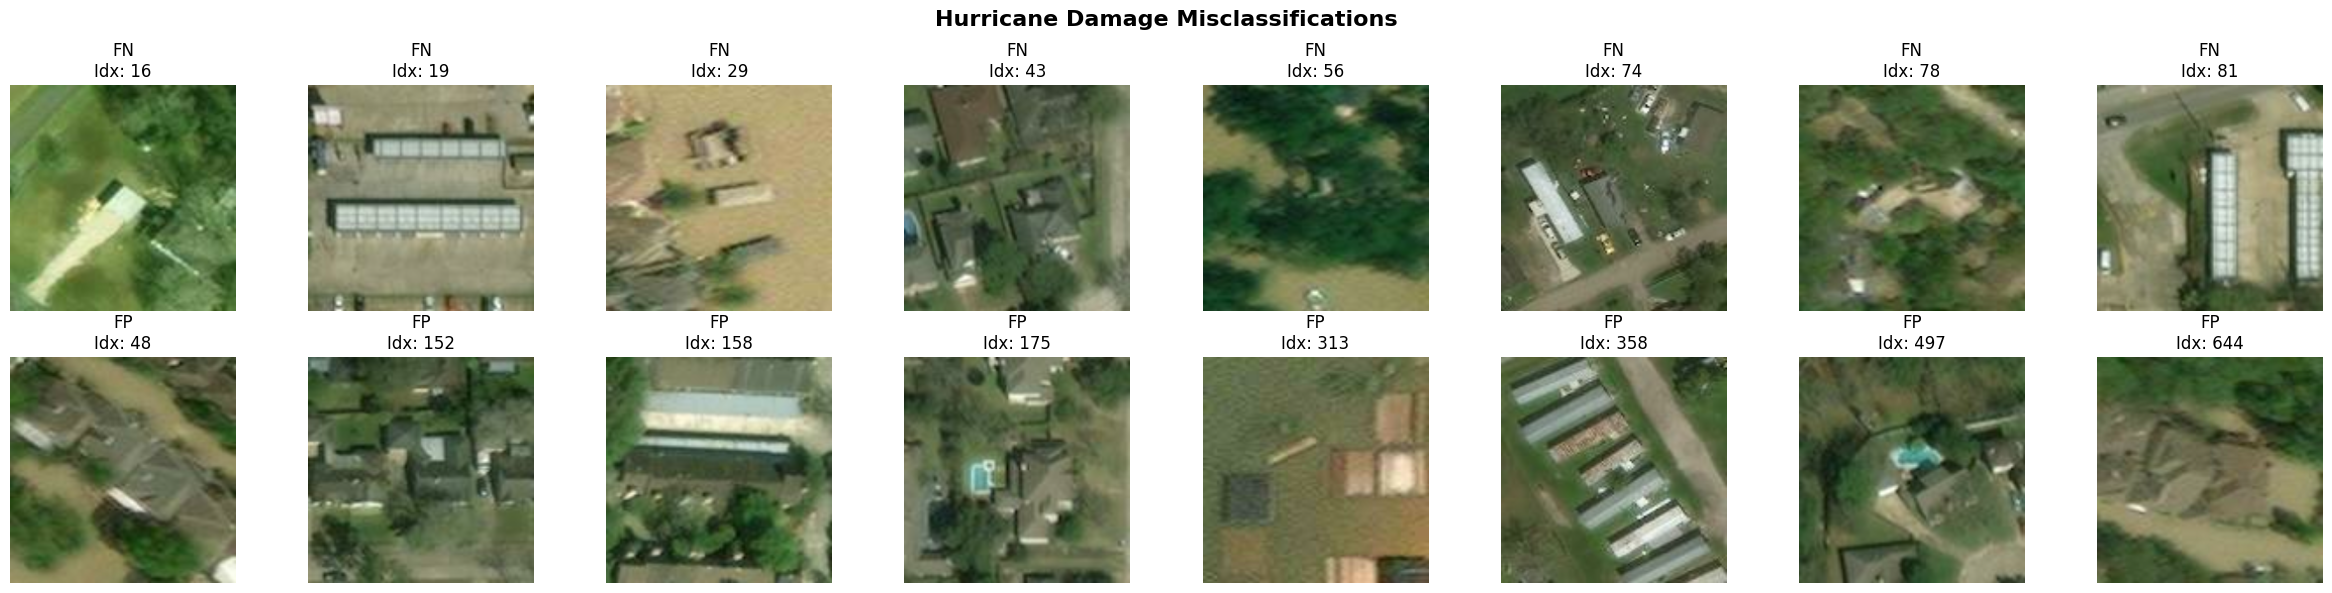

In [34]:
normalize_for_display(images[idx])
plot_false_negatives_positives(
    images=images,
    test_labels=test_labels,
    binary_preds=binary_preds,
    n_show=8,
    title="Hurricane Damage Misclassifications"
)

# Refine the model:

In [35]:
# make all layers trainable
for layer in new_model.layers[:]:
    layer.trainable = True
# make only last layer of resnet50 trainable (except bn)
for layer in new_model.layers[:]:
    if 'conv5' not in layer.name:
        layer.trainable = False
    elif 'bn' in layer.name:
        layer.trainable = False
# Ensure all custom head layers are trainable
for layer in new_model.layers:
    if layer.name not in [l.name for l in base_model.layers]:
        layer.trainable = True

for layer in new_model.layers[:]:
  if layer.trainable == True:
    print(layer.name, layer.trainable)

conv5_block1_1_conv True
conv5_block1_1_relu True
conv5_block1_2_conv True
conv5_block1_2_relu True
conv5_block1_0_conv True
conv5_block1_3_conv True
conv5_block1_add True
conv5_block1_out True
conv5_block2_1_conv True
conv5_block2_1_relu True
conv5_block2_2_conv True
conv5_block2_2_relu True
conv5_block2_3_conv True
conv5_block2_add True
conv5_block2_out True
conv5_block3_1_conv True
conv5_block3_1_relu True
conv5_block3_2_conv True
conv5_block3_2_relu True
conv5_block3_3_conv True
conv5_block3_add True
conv5_block3_out True
global_average_pooling2d True
dropout True
dense True
batch_normalization True
dropout_1 True
dense_1 True


In [36]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [37]:
history1 = new_model.fit(
    train_ds, epochs=20,
    validation_data=val_ds,
)

test_ds, test_labels, predictions = eval_model_on_test(new_model)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 466ms/step - accuracy: 0.9089 - loss: 0.2511 - val_accuracy: 0.9114 - val_loss: 0.1765
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9141 - loss: 0.2190 - val_accuracy: 0.9373 - val_loss: 0.1423
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9270 - loss: 0.2099 - val_accuracy: 0.9410 - val_loss: 0.1400
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9137 - loss: 0.1971 - val_accuracy: 0.9483 - val_loss: 0.1248
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9439 - loss: 0.1489 - val_accuracy: 0.9299 - val_loss: 0.1411
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9425 - loss: 0.1510 - val_accuracy: 0.9446 - val_loss: 0.1343
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9600 - loss: 0.0964 - val_accuracy: 0.9336 - val_loss: 0.1675
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9445 - loss: 0.1396 - val_accuracy: 0

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step


Predicting on Test Data:   1%|          | 1/96 [00:03<06:14,  3.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:04<02:55,  1.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:04<01:52,  1.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:05<01:22,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:05<01:05,  1.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:06<00:55,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:06<00:49,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:06<00:44,  1.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:07<00:41,  2.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:07<00:39,  2.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:08<00:37,  2.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:08<00:36,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:08<00:35,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:09<00:35,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:09<00:34,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:10<00:34,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:10<00:33,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:11<00:32,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:11<00:32,  2.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:11<00:31,  2.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:12<00:31,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:12<00:31,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:13<00:30,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:13<00:30,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:13<00:30,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:14<00:29,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:14<00:29,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:15<00:29,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:15<00:28,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:16<00:28,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:16<00:27,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:16<00:26,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:17<00:26,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:17<00:26,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:18<00:25,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:18<00:25,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:19<00:24,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:19<00:24,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:19<00:23,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:20<00:23,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:20<00:23,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:21<00:22,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:21<00:22,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:22<00:22,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:22<00:21,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:22<00:21,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:23<00:20,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:23<00:20,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:24<00:19,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:24<00:19,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:24<00:18,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:25<00:18,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:25<00:18,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:26<00:17,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:26<00:17,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:27<00:16,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:27<00:16,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:27<00:15,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:28<00:15,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:28<00:14,  2.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:29<00:14,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:29<00:14,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:29<00:13,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:30<00:13,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:30<00:13,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:31<00:12,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:31<00:12,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:32<00:11,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:32<00:11,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:32<00:10,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:33<00:10,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:33<00:10,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:34<00:09,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:34<00:09,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:35<00:08,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:35<00:08,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:35<00:08,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:36<00:07,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:36<00:07,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:37<00:06,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:37<00:06,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:38<00:05,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:38<00:05,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:38<00:05,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:39<00:04,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:39<00:04,  2.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:40<00:03,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:40<00:03,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:41<00:02,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:41<00:02,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:41<00:02,  2.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:42<00:01,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:42<00:01,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:43<00:00,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:43<00:00,  2.39it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


Predicting on Test Data: 100%|██████████| 96/96 [00:47<00:00,  2.04it/s]


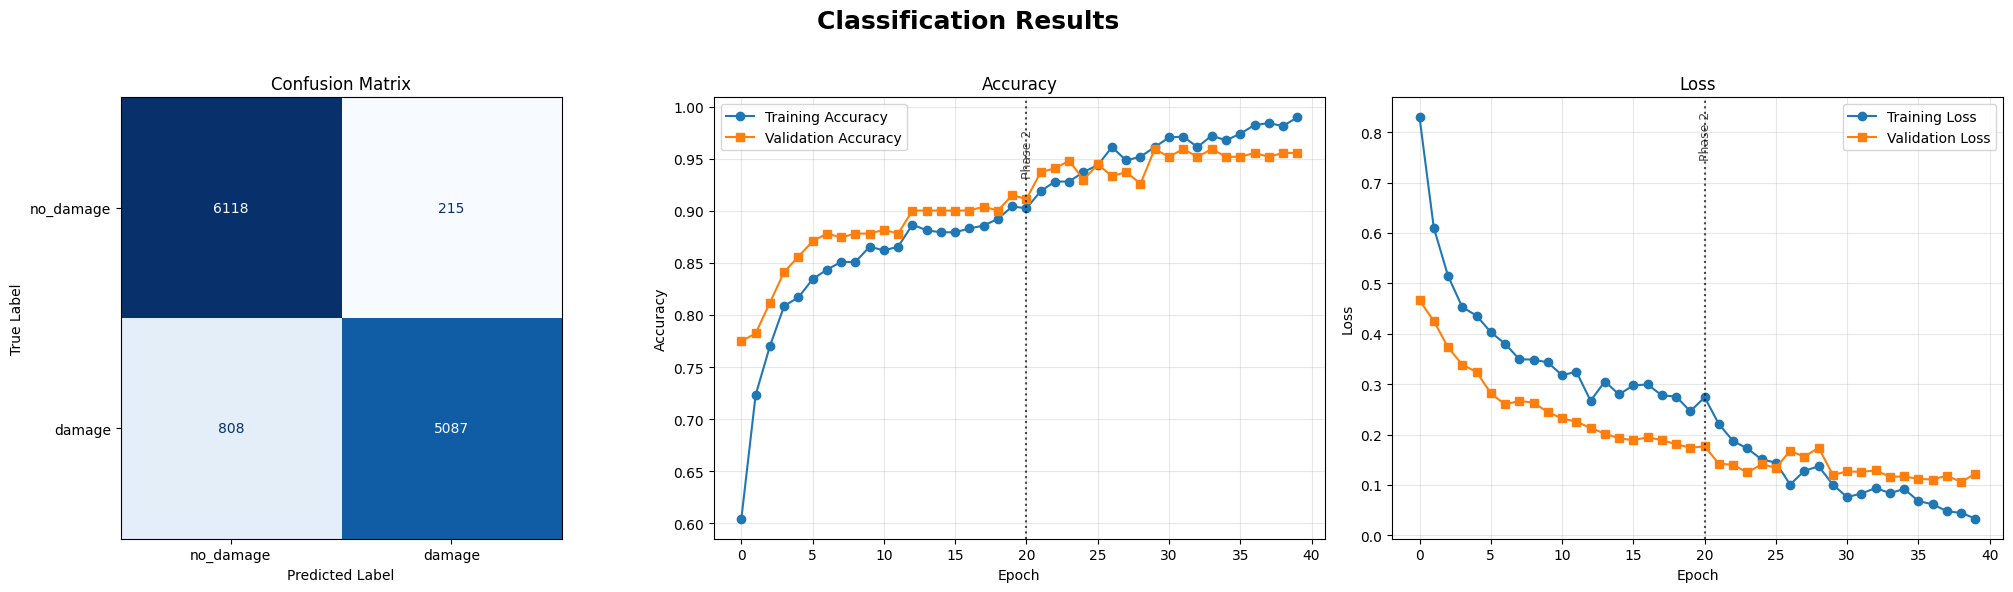

              precision    recall  f1-score   support

   no_damage       0.88      0.97      0.92      6333
      damage       0.96      0.86      0.91      5895

    accuracy                           0.92     12228
   macro avg       0.92      0.91      0.92     12228
weighted avg       0.92      0.92      0.92     12228



In [38]:
plot_classification_summary_multifit(
    predictions=binary_preds,
    test_labels=test_labels,
    histories=[history, history1],
    title="Classification Results",
    class_names=["no_damage", "damage"],
    phase_labels=["Phase 1", "Phase 2"]
)


In [46]:
# Extract all images and labels for easy indexing
images = []
labels = []
for img, lab in test_ds.unbatch():
    images.append(img.numpy())
    labels.append(lab.numpy())
images = np.array(images)
labels = np.array(labels)

false_negatives = np.where((binary_preds == 0) & (test_labels == 1))[0]
false_positives = np.where((binary_preds == 1) & (test_labels == 0))[0]
true_positives  = np.where((binary_preds == 1) & (test_labels == 1))[0]
true_negatives  = np.where((binary_preds == 0) & (test_labels == 0))[0]

def select_image_by_type(images, preds, labels, indices, i=0):
    idx = indices[i]
    return images[idx], preds[idx], labels[idx], idx

image_number = 10
image, pred, label, idx = select_image_by_type(images, binary_preds, test_labels, true_negatives, i=image_number)
print(f"Selected image idx: {idx}, prediction label: {pred}, true label: {label}")
print(image.shape)

Selected image idx: 21, prediction label: 0, true label: 0
(224, 224, 3)


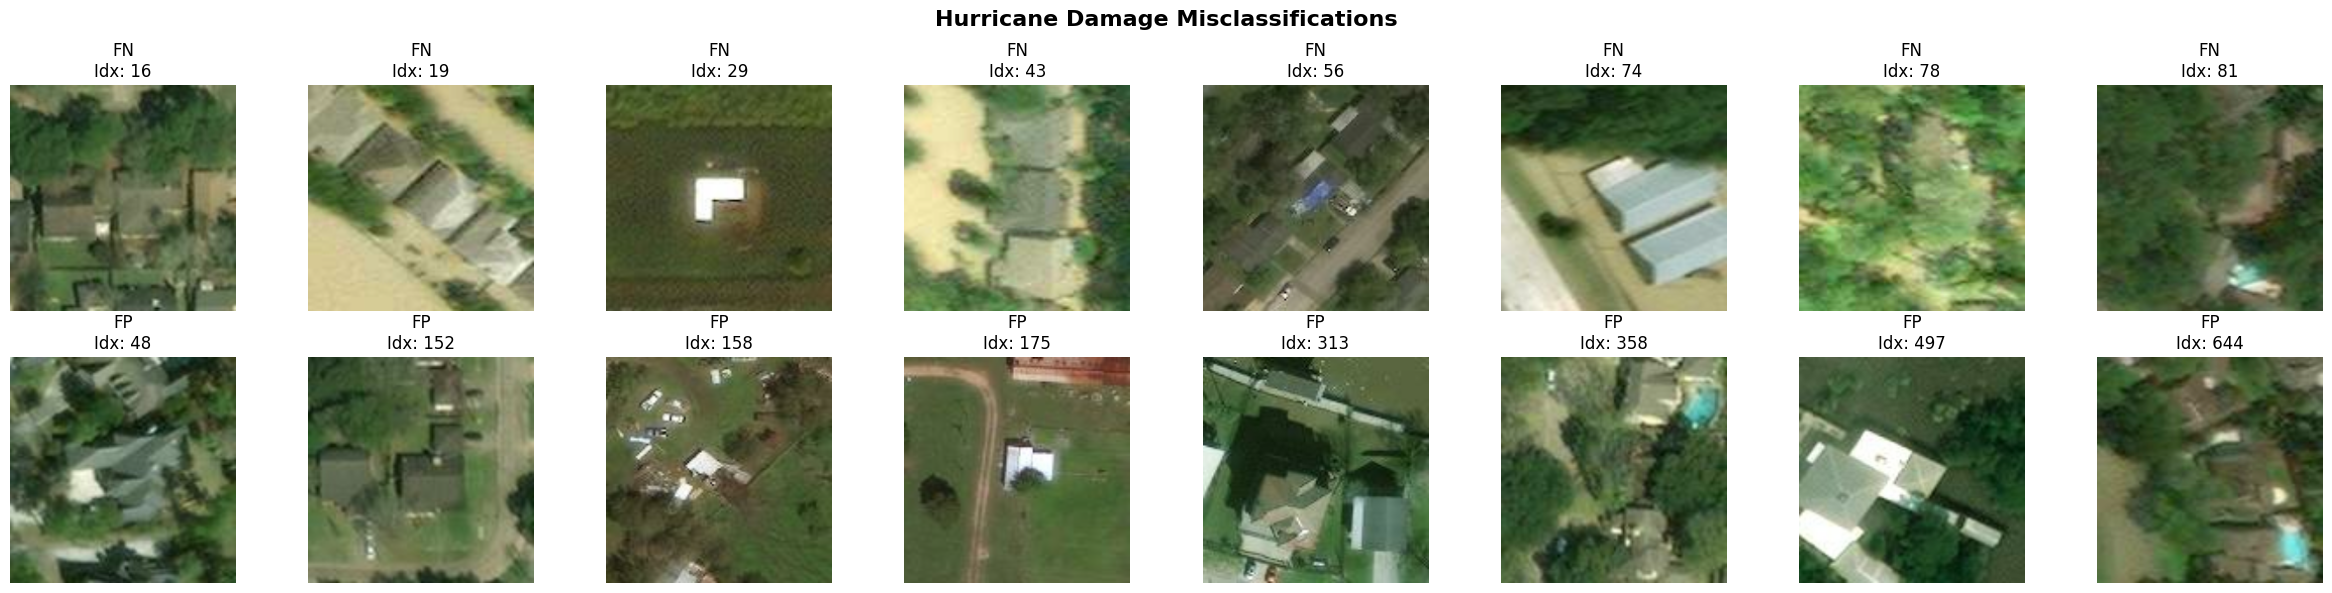

In [47]:
normalize_for_display(images[idx])
plot_false_negatives_positives(
    images=images,
    test_labels=test_labels,
    binary_preds=binary_preds,
    n_show=8,
    title="Hurricane Damage Misclassifications"
)

In [48]:
# Extract all images and labels for easy indexing
images = []
labels = []
for img, lab in test_ds.unbatch():
    images.append(img.numpy())
    labels.append(lab.numpy())
images = np.array(images)
labels = np.array(labels)

false_negatives = np.where((binary_preds == 0) & (test_labels == 1))[0]
false_positives = np.where((binary_preds == 1) & (test_labels == 0))[0]
true_positives  = np.where((binary_preds == 1) & (test_labels == 1))[0]
true_negatives  = np.where((binary_preds == 0) & (test_labels == 0))[0]

In [49]:
image_number = 10
image, pred, label, idx = select_image_by_type(images, binary_preds, test_labels, true_negatives, i=image_number)
print(f"Selected image idx: {idx}, prediction label: {pred}, true label: {label}")
print(image.shape)

Selected image idx: 21, prediction label: 0, true label: 0
(224, 224, 3)


In [50]:
def overlay_heatmap(img, heatmap, alpha=0.4):
    import cv2
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

def select_image_by_type(images, preds, labels, indices, i=0):
    if len(indices) == 0:
        raise ValueError("No samples of this type found.")
    idx = indices[i]
    return images[idx], preds[idx], labels[idx], idx

def plot_gradcam_for_categories(
    images, binary_preds, test_labels, model, loss_func=None, idx_dict=None
):
    # Compute indices for each category
    false_negatives = np.where((binary_preds == 0) & (test_labels == 1))[0]
    false_positives = np.where((binary_preds == 1) & (test_labels == 0))[0]
    true_positives  = np.where((binary_preds == 1) & (test_labels == 1))[0]
    true_negatives  = np.where((binary_preds == 0) & (test_labels == 0))[0]
    categories = [
        ("True Positive", true_positives),
        ("True Negative", true_negatives),
        ("False Positive", false_positives),
        ("False Negative", false_negatives)
    ]
    gradcam = Gradcam(model)
    if loss_func is None:
        def loss(output): return output[:, 0]
    else:
        loss = loss_func

    plt.figure(figsize=(18, 8))
    for col, (cat_name, indices) in enumerate(categories):
        # Index selection: if idx_dict provided, use it, otherwise default to 0
        i = idx_dict.get(cat_name, 0) if idx_dict else 0
        try:
            image, pred, label, idx = select_image_by_type(images, binary_preds, test_labels, indices, i=i)
        except Exception as e:
            print(f"Skipping {cat_name}: {e}")
            continue
        image_input = np.expand_dims(image, axis=0).astype(np.float32)
        heatmap = gradcam(loss, image_input)

        # Original image (top row)
        ax1 = plt.subplot(2, 4, col + 1)
        ax1.set_title(f"{cat_name}\nIdx: {idx}\nPred: {pred}, Label: {label}", fontsize=12)
        ax1.imshow(image.astype("uint8"))
        ax1.axis('off')

        # GradCAM overlay (bottom row)
        ax2 = plt.subplot(2, 4, col + 5)
        ax2.set_title("GradCAM", fontsize=12)
        overlay = overlay_heatmap(image.astype("uint8"), heatmap[0])
        ax2.imshow(overlay)
        ax2.axis('off')

    plt.tight_layout()
    plt.show()


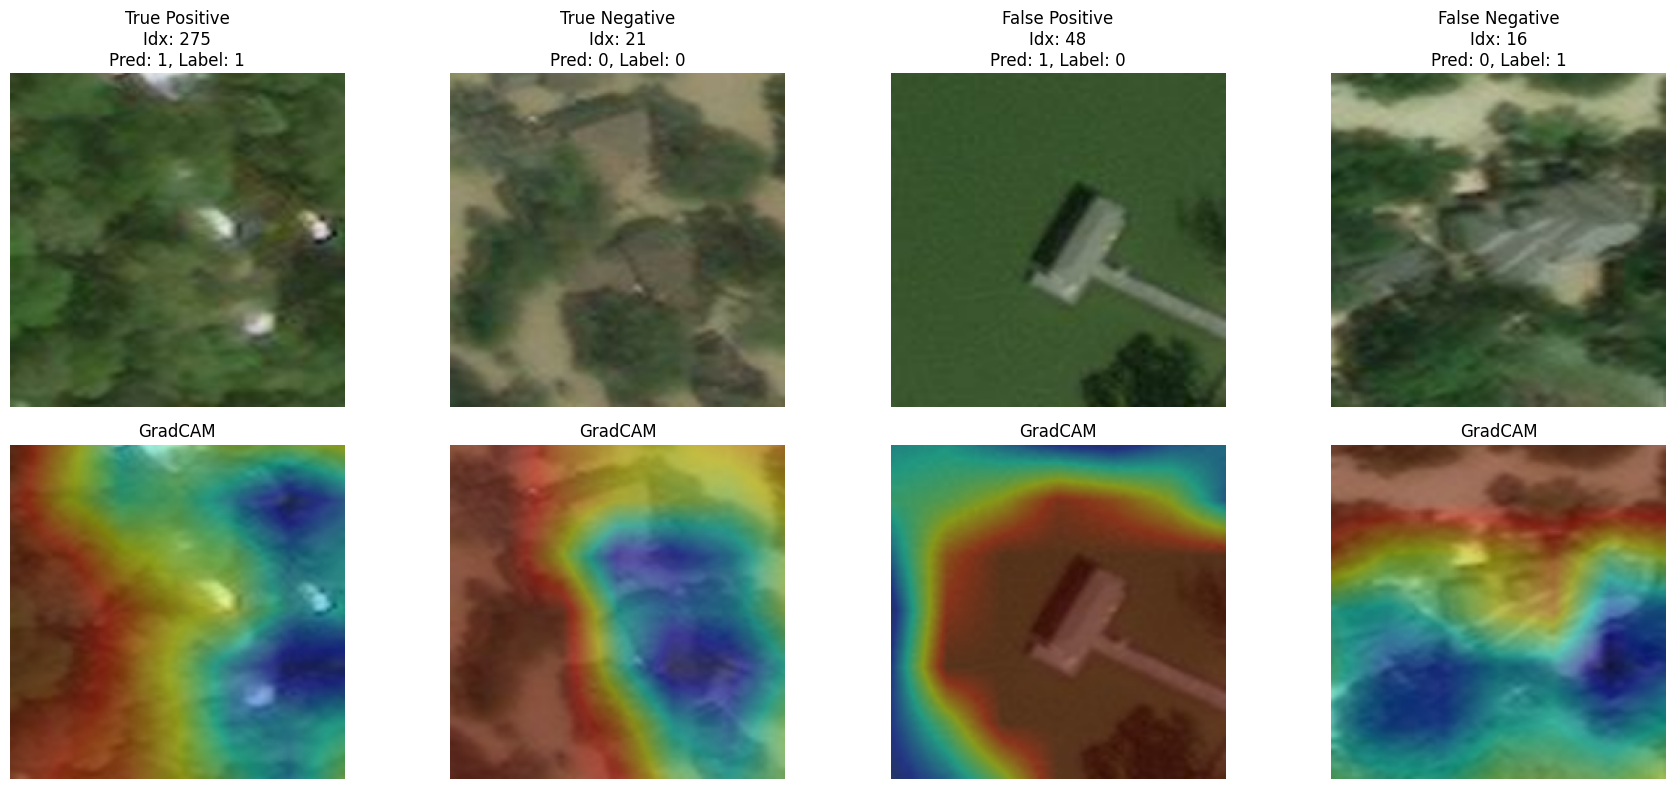

In [51]:
idx_dict = {
    "True Positive": 120,
    "True Negative": 10,
    "False Positive": 0,
    "False Negative": 0
}
plot_gradcam_for_categories(
    images=images,
    binary_preds=binary_preds,
    test_labels=test_labels,
    model=new_model,
    idx_dict=idx_dict
)


In [58]:
def plot_samples_category(
    images: np.ndarray,
    binary_preds: np.ndarray,
    test_labels: np.ndarray,
    n_show: int = 8
) -> None:
    """
    Plots a grid of sample images from each prediction category:
    True Positives, True Negatives, False Positives, False Negatives.

    Args:
        images (np.ndarray): Array of images, shape (N, H, W, C).
        binary_preds (np.ndarray): Binary predictions, shape (N,).
        test_labels (np.ndarray): Ground truth labels, shape (N,).
        n_show (int): Number of samples to show per category.
    """
    # Identify indices for each category
    false_negatives = np.where((binary_preds == 0) & (test_labels == 1))[0]
    false_positives = np.where((binary_preds == 1) & (test_labels == 0))[0]
    true_positives  = np.where((binary_preds == 1) & (test_labels == 1))[0]
    true_negatives  = np.where((binary_preds == 0) & (test_labels == 0))[0]

    categories = [
        ('True Positive', true_positives),
        ('True Negative', true_negatives),
        ('False Positive', false_positives),
        ('False Negative', false_negatives)
    ]

    n_rows = len(categories)
    fig, axes = plt.subplots(n_rows, n_show, figsize=(3 * n_show, 3.5 * n_rows))
    if n_show == 1:
        axes = axes.reshape(-1, 1)

    for row, (cat_name, indices) in enumerate(categories):
        show_count = min(n_show, len(indices))
        for col in range(n_show):
            ax = axes[row, col]
            ax.axis('off')
            if col < show_count:
                idx = indices[col]
                ax.imshow(images[idx].astype("uint8"))
                ax.set_title(f"Idx: {idx}", fontsize=9)
        # Add row label using fig.text
        fig.text(
            0.08,                                        # x-position (left margin)
            1 - (3.5*row + 0.5) / n_rows,                    # y-position (centered per row)
            cat_name,
            va='center', ha='center',
            fontsize=14, fontweight='bold', rotation=90
        )

    plt.suptitle("Sample Images by Prediction Category", fontsize=18, weight='bold')
    plt.tight_layout(rect=[0.08, 0, 1, 0.97])  # Leave room for row labels and title
    plt.show()


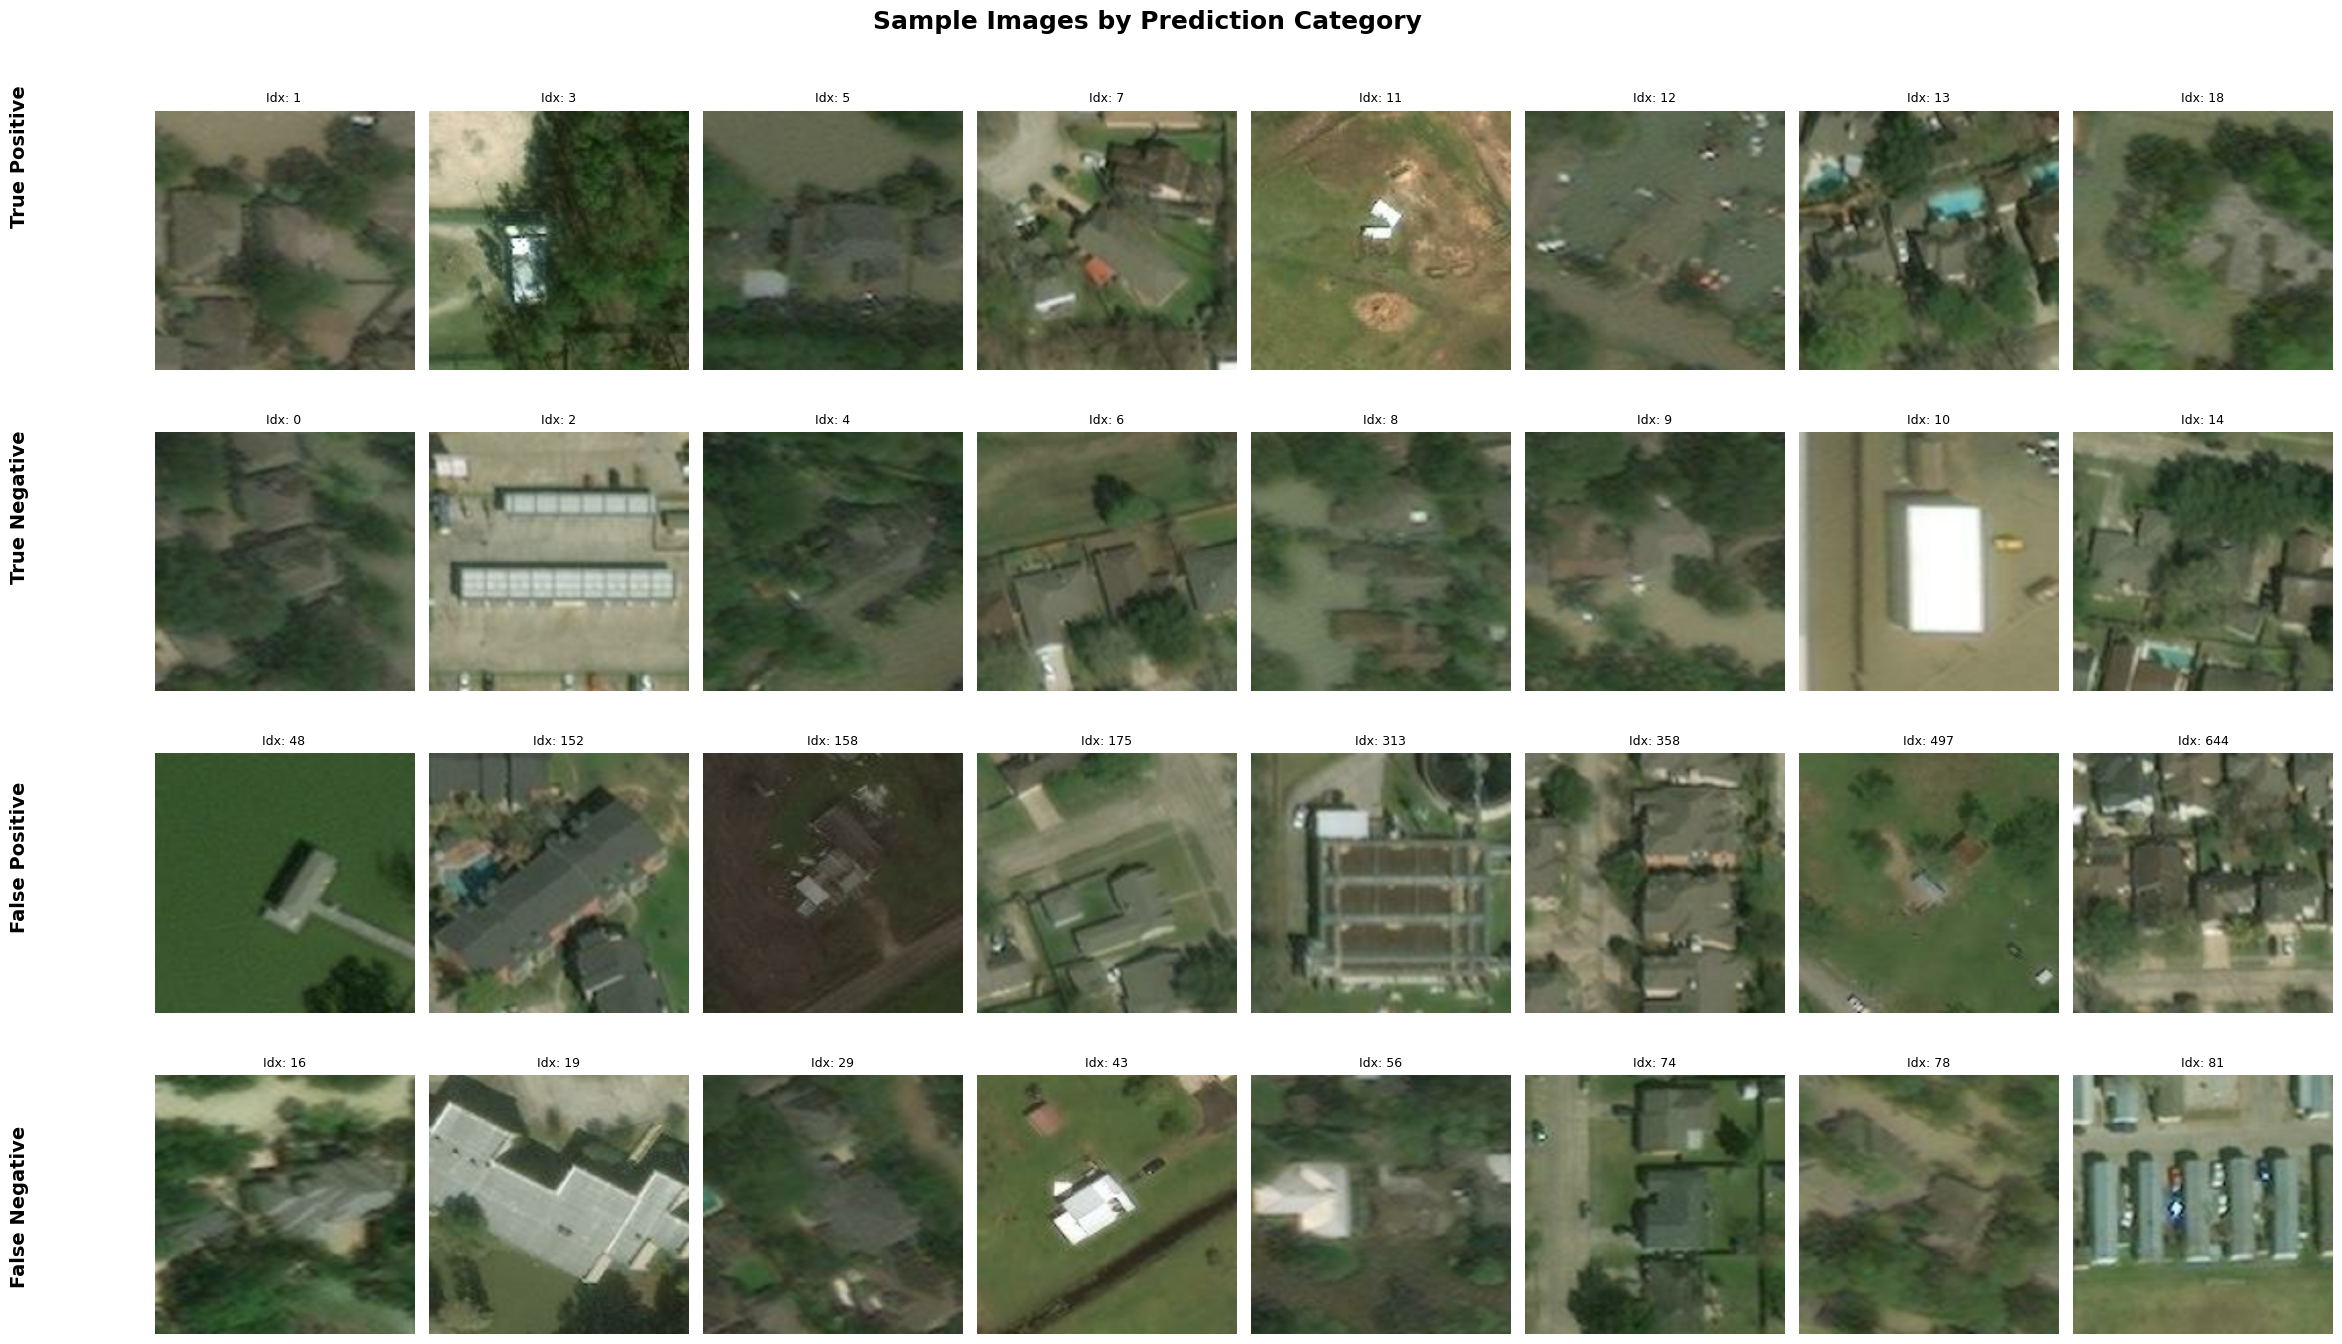

In [57]:
plot_samples_category(
    images=images,
    binary_preds=binary_preds,
    test_labels=test_labels,
    n_show=8
)